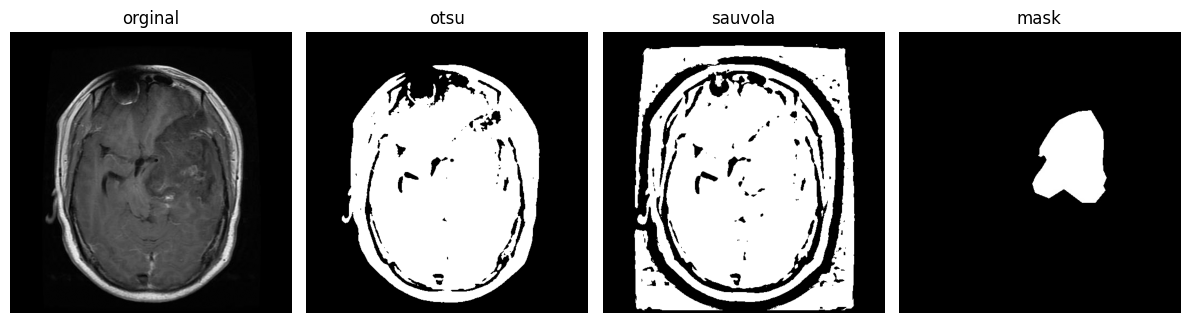

In [4]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

dices1 = []
jaccards1 = []

dices2 = []
jaccards2 = []

def dice(img1, img2):
    img1 = (img1 > 0).astype(np.uint8)
    img2 = (img2 > 0).astype(np.uint8)

    intersect = np.sum(img1 * img2)
    return (2.0 * intersect) / (np.sum(img1) + np.sum(img2) + 1e-8)


def jaccard(img1, img2):
    img1 = (img1 > 0).astype(np.uint8)
    img2 = (img2 > 0).astype(np.uint8)

    intersect = np.sum(img1 * img2)
    union = np.sum(img1) + np.sum(img2) - intersect

    return intersect / (union + 1e-8)

    
def otsu(img):
    img = cv2.GaussianBlur(img, (5,5), 0)
    img = cv2.equalizeHist(img)
    
    img = img.astype(np.int32) 
    d=[0]*256
    st=0
    for i in img:#to count frequencies
        for j in i:
            d[j]+=1
            st+=j
    stn = len(img)*len(img[0])

    scn = 0
    sc = 0
    s = []
    
    for i in range(256):
        scn+=d[i]
        sc+=d[i]*i
        p = scn/stn
        si = p*(1-p)*(sc/(scn+1e-5) - (st-sc)/(stn-scn+1e-5))**2  
        s.append(si)

    k = np.argmax(s)
    return (img > k).astype(np.uint8) * 255


def sauvola(img, win=31, k=0.28):
    
    img = cv2.GaussianBlur(img, (7,7), 0)
    img = img.astype(np.float32) / 255.0

    pad = win // 2
    padded = np.pad(img, pad, mode='reflect')

    out = np.zeros_like(img)

    R = 0.5  

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            patch = padded[i:i+win, j:j+win]

            mean = np.mean(patch)
            std = np.std(patch)

            threshold = mean * (1 + k * ((std / R) - 1))

            out[i, j] = 1 if img[i, j] > threshold else 0

    return (out * 255).astype(np.uint8)

  
def segment(path1):
    path2 = path1.replace('images','masks').replace('jpg','png')#changes image to mask path
    img1 = cv2.imread(path1, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(path2, cv2.IMREAD_GRAYSCALE)

    thresh1 = otsu(img1)
    dices1.append(dice(thresh1,img2))
    jaccards1.append(jaccard(thresh1,img2))

    thresh2 = sauvola(img1)
    dices2.append(dice(thresh2,img2))
    jaccards2.append(jaccard(thresh2,img2))

    return img1,thresh1,thresh2,img2
    
    
#dataset: https://www.kaggle.com/datasets/briscdataset/brisc2025

img1,k1,k2,img2 = segment('/kaggle/input/datasets/briscdataset/brisc2025/brisc2025/segmentation_task/train/images/brisc2025_train_00001_gl_ax_t1.jpg')


plt.figure(figsize=(12,6))

plt.subplot(1,4,1)
plt.imshow(img1, cmap='gray')
plt.title("orginal")
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(k1, cmap='gray')
plt.title("otsu")
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(k2, cmap='gray')
plt.title("sauvola")
plt.axis('off')

plt.subplot(1,4,4)
plt.imshow(img2, cmap='gray')
plt.title("mask")
plt.axis('off')

plt.tight_layout()
plt.show()

In [7]:
import os


def process_folder(folder_path):
    limit =30
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            img_path = os.path.join(root, file)
            print(img_path)
            segment(img_path)
            limit -= 1
            if limit <= 0:
                break


folder_path = "/kaggle/input/datasets/briscdataset/brisc2025/brisc2025/segmentation_task/train/images"
process_folder(folder_path)


/kaggle/input/datasets/briscdataset/brisc2025/brisc2025/segmentation_task/train/images/brisc2025_train_04966_pi_sa_t1.jpg
/kaggle/input/datasets/briscdataset/brisc2025/brisc2025/segmentation_task/train/images/brisc2025_train_01914_me_co_t1.jpg
/kaggle/input/datasets/briscdataset/brisc2025/brisc2025/segmentation_task/train/images/brisc2025_train_00160_gl_ax_t1.jpg
/kaggle/input/datasets/briscdataset/brisc2025/brisc2025/segmentation_task/train/images/brisc2025_train_03927_pi_ax_t1.jpg
/kaggle/input/datasets/briscdataset/brisc2025/brisc2025/segmentation_task/train/images/brisc2025_train_03781_pi_ax_t1.jpg
/kaggle/input/datasets/briscdataset/brisc2025/brisc2025/segmentation_task/train/images/brisc2025_train_00395_gl_co_t1.jpg
/kaggle/input/datasets/briscdataset/brisc2025/brisc2025/segmentation_task/train/images/brisc2025_train_04275_pi_co_t1.jpg
/kaggle/input/datasets/briscdataset/brisc2025/brisc2025/segmentation_task/train/images/brisc2025_train_04469_pi_co_t1.jpg
/kaggle/input/datasets/b

In [6]:
print('otsu mean')
print('dice:', f"{np.mean(dices1):.3f}")
print('jaccard:', f"{np.mean(jaccards1):.3f}", '\n')

print('sauvola mean')
print('dice:', f"{np.mean(dices2):.3f}")
print('jaccard:', f"{np.mean(jaccards2):.3f}")

otsu mean
dice: 0.098
jaccard: 0.053 

sauvola mean
dice: 0.069
jaccard: 0.037
